# Transfer Learning: Fine Tuning


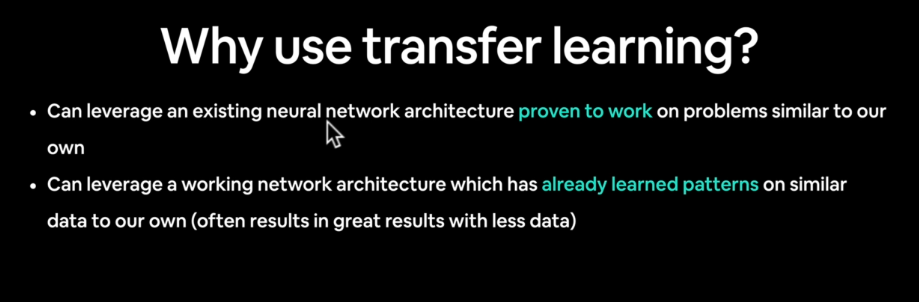

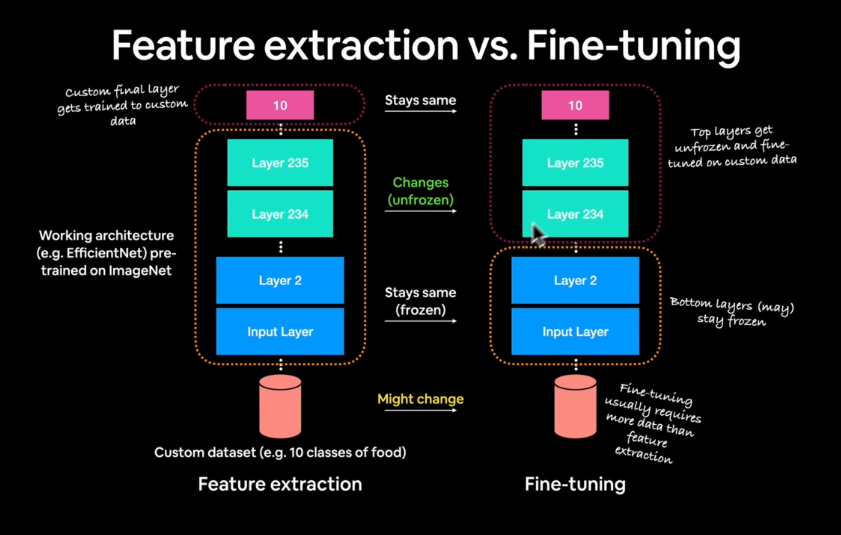

In [2]:
# creating helper functions

# Put all function in a script and use from there

In [3]:
!wget https://raw.githubusercontent.com/fx818/TensorFlow/refs/heads/main/extras/helper_functions.py

--2024-11-21 13:05:37--  https://raw.githubusercontent.com/fx818/TensorFlow/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-11-21 13:05:38 (17.3 MB/s) - 'helper_functions.py' saved [10246/10246]



In [4]:
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir, load_and_prep_image

## Let's get some data

> Using the models inside tf.keras.applications and apply them to our problem

In [5]:
# Get 10% of data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



unzip_data("10_food_classes_10_percent.zip")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-21 13:05:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 142.250.99.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

10_food_classes_10_ 100%[===================>] 160.74M   113MB/s    in 1.4s    

2024-11-21 13:05:52 (113 MB/s) - '10_food_classes_10_percent.zip' saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [7]:
# training and testing dir

train_dir = "10_food_classes_10_percent/train"

test_dir = "10_food_classes_10_percent/test"


> Instead of ImageDataGenerator we will use `image_dataset_from_directory`

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_perc = image_dataset_from_directory(
    directory=train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size= BATCH_SIZE,
)


test_data = image_dataset_from_directory(
    directory = test_dir,
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_perc

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_perc.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for image, labels in train_data_10_perc.take(1):

  print(image, labels)

tf.Tensor(
[[[[ 45.05612     31.056124    31.056124  ]
   [ 47.16837     35.16837     35.16837   ]
   [ 51.362244    39.362244    39.362244  ]
   ...
   [ 94.21433    101.64286    109.00007   ]
   [106.32641    110.54073    119.46929   ]
   [ 95.48492    104.02576    113.25533   ]]

  [[ 51.30612     39.30612     39.30612   ]
   [ 55.64286     43.64286     43.64286   ]
   [ 57.214287    45.214287    45.214287  ]
   ...
   [ 94.39792    103.68359    110.11223   ]
   [ 94.48982    101.6225     111.55616   ]
   [ 93.887726   104.83681    113.50514   ]]

  [[ 56.92347     45.35204     45.566326  ]
   [ 55.48469     43.913265    44.12755   ]
   [ 58.62245     48.66837     48.09694   ]
   ...
   [ 94.95406    104.33668    112.83163   ]
   [ 94.49491    104.72454    113.867386  ]
   [ 92.510185   108.14803    116.57658   ]]

  ...

  [[ 34.653133    56.224606    53.43887   ]
   [ 35.857254    60.01548     56.30117   ]
   [ 28.928593    53.2858      49.500065  ]
   ...
   [134.35721    121.214

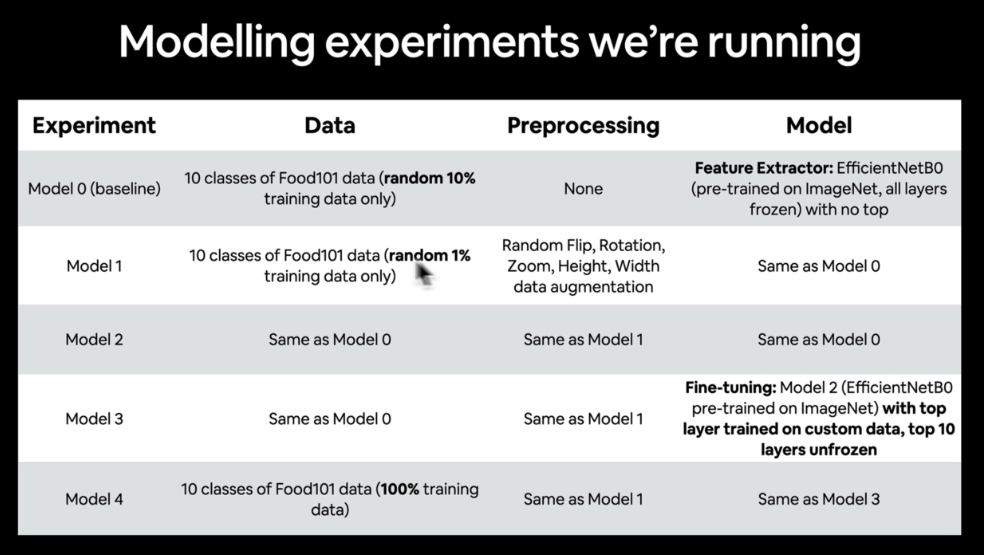

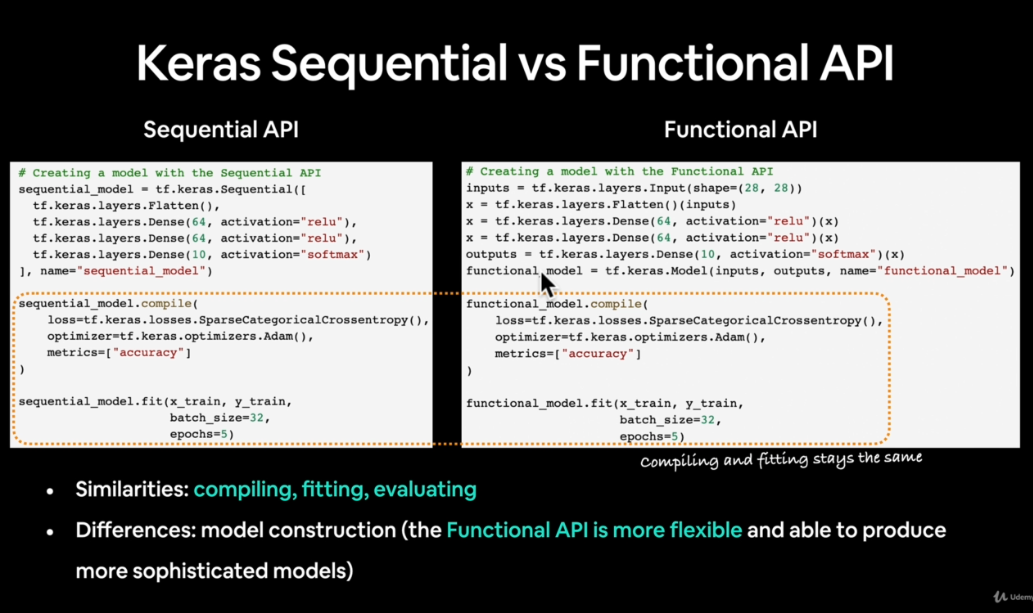

## Build a model using `Function API`

## Feature extraction model

In [12]:
import tensorflow as tf



# Create the model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# Freeze the base model (so underlying pre trained patterns aren't updated)
base_model.trainable = False

# Create input into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# If using model like resnet50v2 you will need to normalise inputs not for EfficientNet(s)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# pass the input to base model
x = base_model(inputs)
print(f"Shape after passing the input through base model: {x.shape} ")

# Average pool the output of the base model (aggregate all the most imp info, reduce no of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after Global average pooling: {x.shape} ")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

# Combine the input and output layer in a model
model0 = tf.keras.Model(inputs, outputs)

# Compile the model
model0.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model0.fit(
    train_data_10_perc,
    epochs = 5,
    validation_data = test_data
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing the input through base model: (None, 7, 7, 1280) 
Shape after Global average pooling: (None, 1280) 
Epoch 1/5


I0000 00:00:1732194367.274211     105 service.cc:145] XLA service 0x7ff81001e610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732194367.274281     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732194367.274286     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.1484 - loss: 2.4434 

I0000 00:00:1732194386.856657     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.2691 - loss: 2.1606 - val_accuracy: 0.6608 - val_loss: 1.4083
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7284 - loss: 1.2706 - val_accuracy: 0.7764 - val_loss: 0.9828
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7888 - loss: 0.9183 - val_accuracy: 0.7992 - val_loss: 0.8049
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.8313 - loss: 0.7267 - val_accuracy: 0.8164 - val_loss: 0.7109
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8464 - loss: 0.6555 - val_accuracy: 0.8248 - val_loss: 0.6557


In [13]:
history0 = model0.history

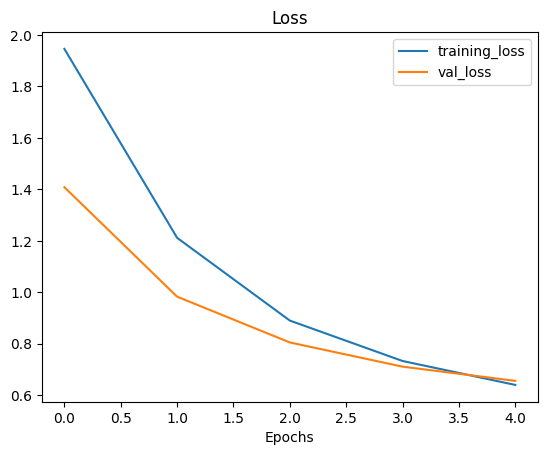

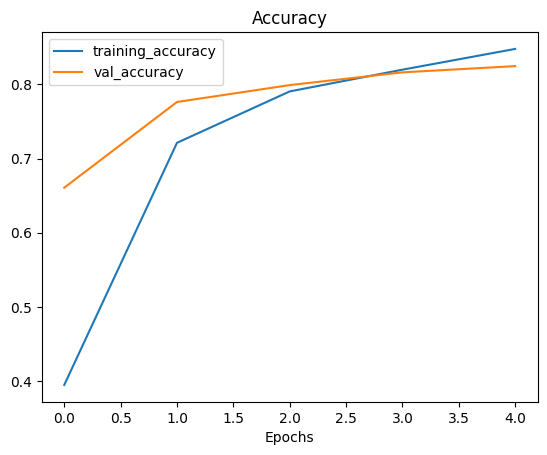

In [14]:
plot_loss_curves(history0)

In [15]:
model0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8113 - loss: 0.6678


[0.6556516885757446, 0.8248000144958496]

In [16]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [17]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [18]:
model0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)



## Getting a feature vector from a trained model



Let's demonstrate the `Global Average Pooling 2D layer`



* We had a tensor after our model0 goes through `base model` of shape (None, 7, 7, 1280).



* But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).



* Let's use a similar shaped tensor of (1, 4, 4, 4) and then pass it to GlobalAveragePooling2D


In [19]:
import tensorflow as tf



# Define the input shape
input_shape = (1, 4, 4, 3)

# Creating a random tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"The rnadom input tensor is: \n {input_tensor} ")

# Pass the random tensor to the global avg ppoling
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"The global avg pooled tensor is: \n {global_average_pooled_tensor}")

print(f"shape of input tensor: {input_tensor.shape}")

print(f"shape of pooled tensor: {global_average_pooled_tensor.shape}")

The rnadom input tensor is: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 
The global avg pooled tensor is: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]
shape of input tensor: (1, 4, 4, 3)
shape of pooled tensor: (1, 3)


In [20]:
# Let's replicate the GolablAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

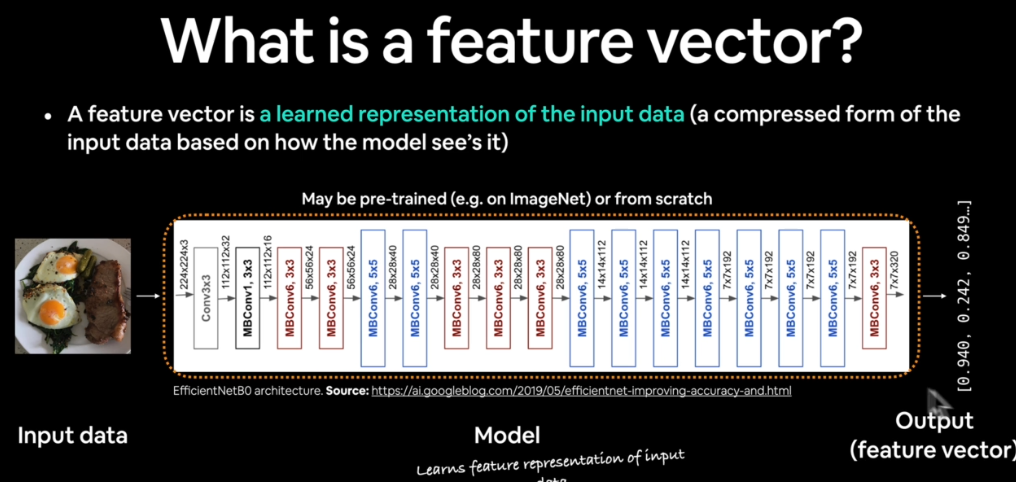

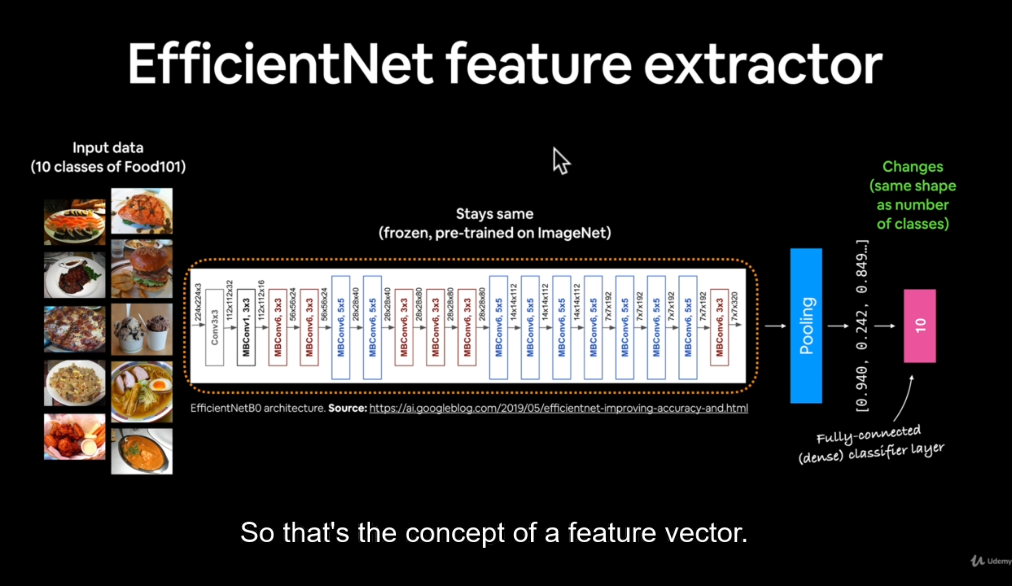

## Running a series of Transfer Learning experiments

### Getting and preprocessing data for `model1`

In [21]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-11-21 13:08:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.203.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: '10_food_classes_1_percent.zip'

10_food_classes_1_p 100%[===================>] 127.42M  78.7MB/s    in 1.6s    

2024-11-21 13:08:09 (78.7 MB/s) - '10_food_classes_1_percent.zip' saved [133612354/133612354]



In [22]:
# creating train and test dir
train_dir_1_perc = "10_food_classes_1_percent/train"
test_data = "10_food_classes_1_percent/test"

In [23]:
# checking the no of images
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [24]:
# Setup data loaders

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_perc = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_perc,
                                                                        label_mode = "categorical",
                                                                        image_size = IMG_SIZE,
                                                                        batch_size = BATCH_SIZE
                                                                        )


test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )




Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


### Adding data augmentation into the model



We can us the layer inside (any one them)



`tf.keras.layers.experimental.preprocessing()`



`tf.keras.layers.preprocessing()`



`tf.keras.layers`



Benefits:

* Preprocessing of images (augmentation) happens on the GPU rather than CPU

* Image data Augmentation only happens during training, so we can still export our mode and use it elsewhere.

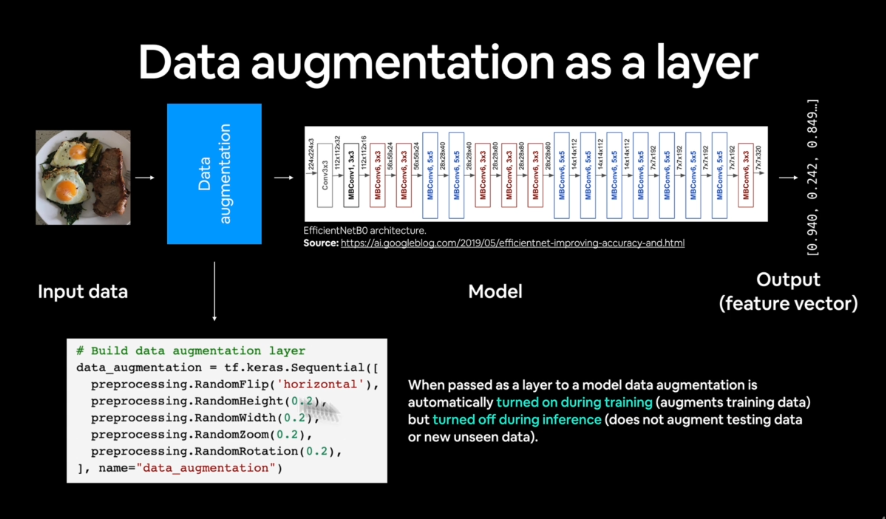

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    # Rescaling(1/255.),
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    Resizing(224, 224),
    Rescaling(1/255.) # Not for efficientnet

], name = 'data_augmentation')

### Visualizing our data augmentation layer


In [26]:
# # View random image and compare it to augmented version

# import matplotlib.pyplot as plt

# import matplotlib.image as mpimg

# import os

# import random



# target_class = random.choice(train_data_1_perc.class_names)

# target_dir = "10_food_classes_1_percent/train/" + target_class



# random_image = random.choice(os.listdir(target_dir))

# random_image_path = target_dir + '/' + random_image



# # Read in random img

# img = mpimg.imread(random_image_path)

# plt.imshow(img)

# plt.title(f"Original random image from class {target_class}")

# plt.axis(False)



# # Lets plot the augmented random image

# aug_img = data_augmentation(tf.expand_dims(img, axis = 0))

# plt.figure()

# plt.imshow(tf.squeeze(aug_img)/255.)

# plt.title(f"Augmented random image from class {target_class}")

# plt.axis(False)

In [27]:
print(data_augmentation.summary())

Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height (RandomHeight)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width (RandomWidth)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
for images, labels in train_data_1_perc.take(1):

    print("Image batch shape:", images.shape)

    print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)


In [29]:
# Model 1 Feature extraction on 1% of data with augmentation

base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  weights='imagenet')

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=(224, 224, 3), name = 'input_layer')

# Add in the data augmentation
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool the output features
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as thr output
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the input and outputs
model1 = keras.Model(inputs, outputs)

model1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']

)


history1 = model1.fit(
    train_data_1_perc,
    epochs = 5,
    validation_data = test_data
)


Epoch 1/5


2024-11-21 13:08:23.385413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.0709 - loss: 2.3103 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 871ms/step - accuracy: 0.1307 - loss: 2.3037 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 885ms/step - accuracy: 0.0670 - loss: 2.3063 - val_accuracy: 0.1000 - val_loss: 2.3038
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 876ms/step - accuracy: 0.0969 - loss: 2.3067 - val_accuracy: 0.1000 - val_loss: 2.3046
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - accuracy: 0.1164 - loss: 2.3034 - val_accuracy: 0.1000 - val_loss: 2.3053


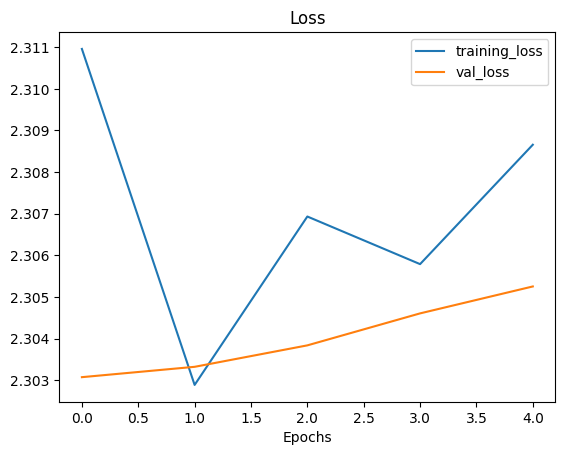

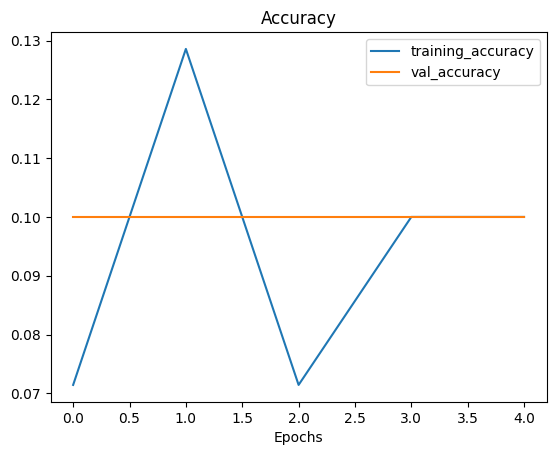

In [30]:
plot_loss_curves(history1)

In [31]:
model1.evaluate(test_data)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.0957 - loss: 2.3059


[2.3052542209625244, 0.10000000149011612]

In [32]:
model1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

## Feature extracting `model2` with 10% of data

In [81]:
# Get the 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_perc = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

--2024-11-21 13:49:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 173.194.203.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip.2'

10_food_classes_10_ 100%[===================>] 160.74M   233MB/s    in 0.7s    

2024-11-21 13:49:01 (233 MB/s) - '10_food_classes_10_percent.zip.2' saved [168546183/168546183]



In [82]:
# Set the data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_perc = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_perc,
                                                                        label_mode = 'categorical',
                                                                         image_size = IMG_SIZE
                                                                        )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                               image_size = IMG_SIZE
                                                               )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [83]:
# Create model2 with data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

# Build data aug layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomRotation(0.2),
    Rescaling(1/255.),
    Resizing(224,224)
], name = "data_augmenations")

In [84]:
data_augmentation.summary()

Model: "data_augmenations"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_2 (RandomHeight)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_2 (RandomWidth)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [85]:
# set up the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input and outputs

inputs = layers.Input(shape = input_shape, name = 'Input_Layer')

x = data_augmentation(inputs)
x = base_model(x, training = False)

x = GlobalAveragePooling2D(name='global_avg_pooling_2D')(x)

outputs = layers.Dense(10, activation = 'softmax', name = "Output_Layer")(x)


model2 = tf.keras.Model(inputs, outputs)

model2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)




In [86]:
model2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmenations (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling_2D           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Creating a ModelCheckpoint
> The ModelCheckpoint callback immediately saves our model (the full model or just the weights) during training. This is usefull so we can come and start where we left off

In [87]:
# Set checkpoint path - where checkpoints get saved
checkpoint_path = "ten_perc_modelcheckpoints_weight/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                        save_weights_only = True,
                                                        save_best_only = False,
                                                        save_freq = 'epoch',
                                                        verbose = 1)


In [88]:
# fit the model
initial_epochs = 10

history2 = model2.fit(
    train_data_10_perc,
    epochs = initial_epochs,
    validation_data = test_data,
    callbacks = [checkpoint_callback]
    
)

Epoch 1/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0769 - loss: 2.3081
Epoch 1: saving model to ten_perc_modelcheckpoints_weight/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step - accuracy: 0.0774 - loss: 2.3086 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 2/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0847 - loss: 2.3066
Epoch 2: saving model to ten_perc_modelcheckpoints_weight/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.0843 - loss: 2.3067 - val_accuracy: 0.1000 - val_loss: 2.3036
Epoch 3/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1014 - loss: 2.3063
Epoch 3: saving model to ten_perc_modelcheckpoints_weight/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.0999 - loss: 2.3064 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 4/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0672 - loss: 2.3064
Epoch 4: saving model to ten_perc_modelcheckpoints_weight/checkpoint

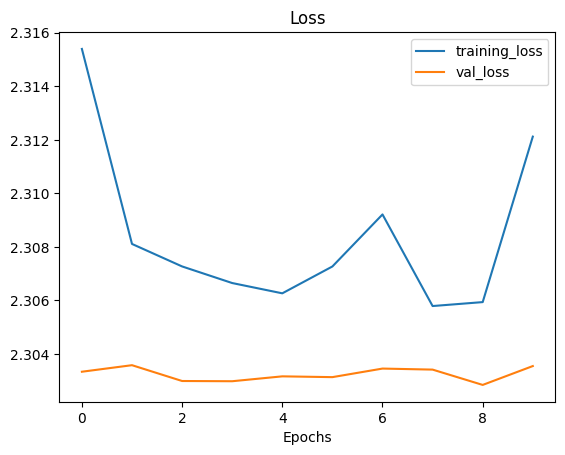

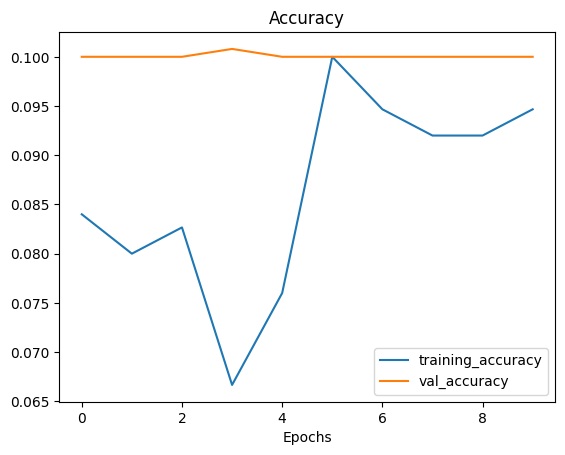

In [89]:
plot_loss_curves(history2)

In [90]:
savedmodel_eval = model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.0914 - loss: 2.3033


In [91]:
model0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8329 - loss: 0.6494


[0.6556514501571655, 0.8248000144958496]

### Loading in checkpointed weights
* Loading in checkpointed weights return a model to specific checkpoint

In [92]:
# Load in saved model's weight and evaluate
model2.load_weights(checkpoint_path)

In [93]:
# Evaluate model2  with loaded weights
loadedmodel_eval = model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.0966 - loss: 2.3029


In [94]:
# Additionally you can use numpy.isclose to find whether the above 2 results are close or not
import numpy as np
np.isclose(np.array(savedmodel_eval), np.array(loadedmodel_eval))

array([ True,  True])

### Model2: Finetuning existing model with 10% of the data
> Finetuning usually works best after training a feature extraction model for a few epochs with large amount of custom data

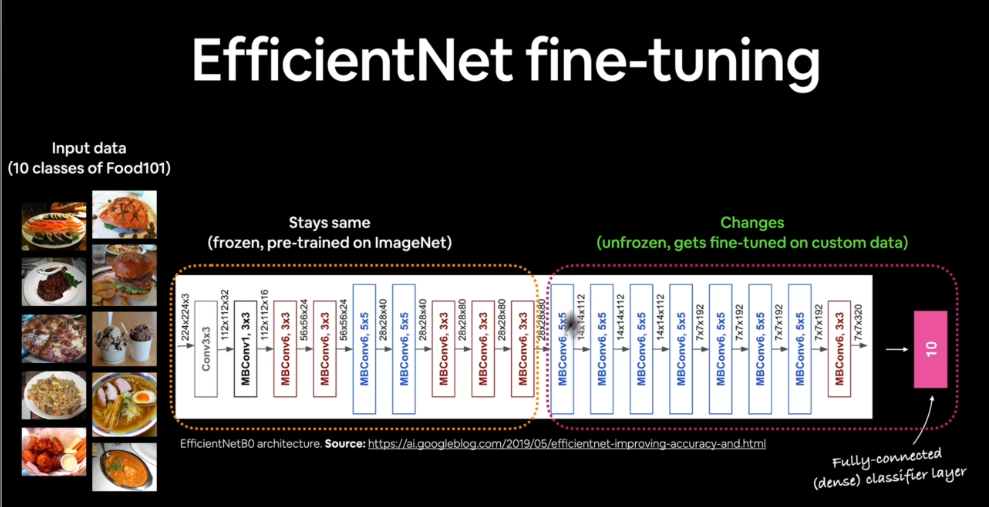

In [95]:
# model3 is a finetuned version of model2 
model2.layers

[<InputLayer name=Input_Layer, built=True>,
 <Sequential name=data_augmenations, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_avg_pooling_2D, built=True>,
 <Dense name=Output_Layer, built=True>]

In [96]:
for layer in model2.layers:
    print(layer, layer.trainable)

<InputLayer name=Input_Layer, built=True> True
<Sequential name=data_augmenations, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_avg_pooling_2D, built=True> True
<Dense name=Output_Layer, built=True> True


In [97]:
# What layers are in our base model (EfficientNetB0) and are they trainable
for i, layer in enumerate(model2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_9 False
2 normalization_3 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squee

In [98]:
# How many trainable variable are in our base model
print(len(model2.layers[2].trainable_variables))

0


> When using finetuning we should lower our learning rate by 10x generally

In [99]:
# to begin finetuning, lets start by setting the last 10 layers of our base_model.trainable to True
base_model.trainable = True

# Freeze all the layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile our model everytime we make change
model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    # When finetuning we wanna lower the lr by 10X
    metrics = ['accuracy']
)


In [100]:
# Check which layer are tunable (trainable)
for layer_number, layer in enumerate(model2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_9 False
2 normalization_3 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squee

In [101]:
# Now we have unfrozen some of the layers closer to the top
# Lets see how many of them are trainable
print(len(model2.trainable_variables))

12


In [103]:
# Lets finetune for another 5 epochs
finetune_epochs = initial_epochs + 5

# Refit the model same as model2 except with more trainable layers
history3 = model2.fit(
    train_data_10_perc,
    epochs = finetune_epochs,
    validation_data = test_data,
    initial_epoch = history2.epoch[-1], # finetune from prev last epochs
    # callbacks = [] # If you want any callbacks
)

Epoch 10/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.0929 - loss: 2.3283 - val_accuracy: 0.1000 - val_loss: 2.3734
Epoch 11/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.0898 - loss: 2.3152 - val_accuracy: 0.1000 - val_loss: 2.3626
Epoch 12/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.0937 - loss: 2.3129 - val_accuracy: 0.1000 - val_loss: 2.3553
Epoch 13/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.0866 - loss: 2.3185 - val_accuracy: 0.1000 - val_loss: 2.3412
Epoch 14/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.1009 - loss: 2.3054 - val_accuracy: 0.1000 - val_loss: 2.3337
Epoch 15/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.1055 - loss: 2.3176 - val_accuracy: 0.1000 - val_loss: 2.3353


In [104]:
# Evaluate finetuned model (model3 which is finetuned on model2 for further 5 epochs)
finetune_res = model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.1105 - loss: 2.3360


In [105]:
finetune_res

[2.3352973461151123, 0.10000000149011612]

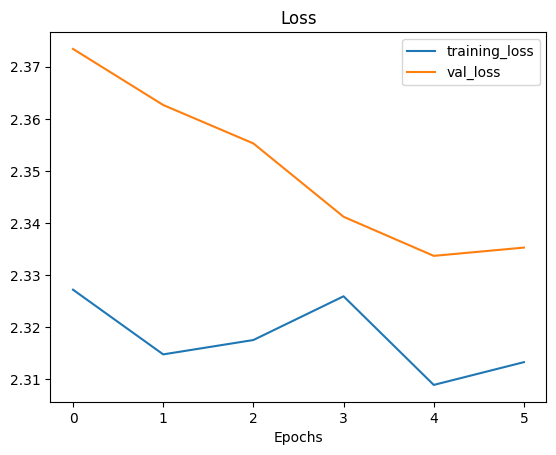

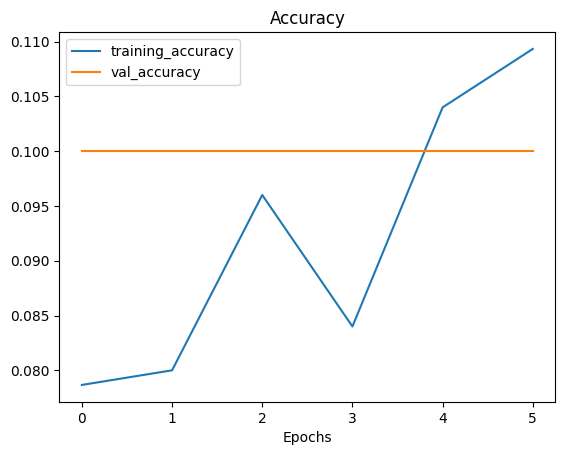

In [106]:
plot_loss_curves(history3)

## Comparing the model's result before and after finetuning

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after finetuning)


In [107]:
# Lets create a funcrion to compare training histories
import matplotlib.pyplot as plt

def compare_history(original_hist, new_hist, initial_epochs):
    """
    Compares the Tensorflow history objectrs
    """
    # Get original history measurements
    acc = original_hist.history['accuracy']
    loss = original_hist.history['loss']
    
    val_acc = original_hist.history['val_accuracy']
    val_loss = original_hist.history['val_loss']

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_hist.history['accuracy']
    total_loss = loss + new_hist.history['loss']
    
    total_val_acc = val_acc + new_hist.history['val_accuracy']
    total_val_loss = val_loss + new_hist.history['val_loss']

    # make accuracy plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label = "Training Accuracy")
    plt.plot(total_val_acc, label = "Val Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower left")
    plt.title("Training and Validation Accuracy")

    # make loss plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label = "Training Loss")
    plt.plot(total_val_loss, label = "Val Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    




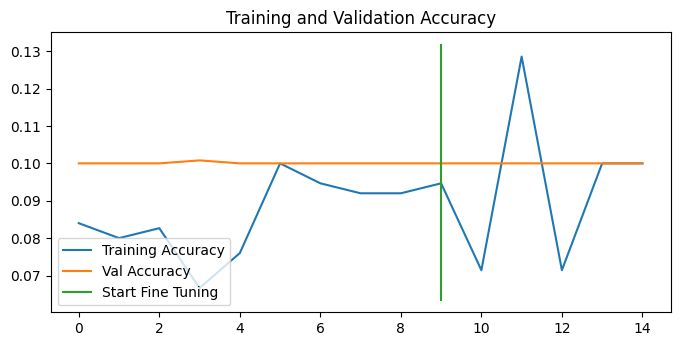

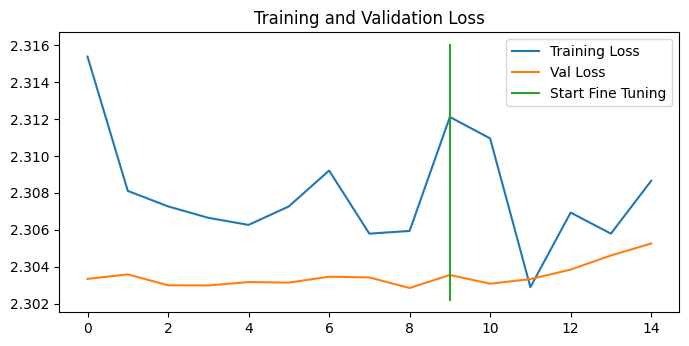

In [108]:
compare_history(history2, history1, initial_epochs)

## Finetuning an existing model an all of our data

In [109]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-11-21 13:52:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.142.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip.1'

10_food_classes_all 100%[===================>] 495.13M   194MB/s    in 2.5s    

2024-11-21 13:52:30 (194 MB/s) - '10_food_classes_all_data.zip.1' saved [519183241/519183241]



In [110]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [111]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [112]:
# set data inputs
import tensorflow as tf
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = 'categorical',
                                                                    image_size = IMG_SIZE,
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size = IMG_SIZE
                                                               )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [113]:
train_data_all.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

The test dataset we have loaded in is the same as whta we've been using for previous experiments (all experiments have used the dataset).

Let's verify this

In [114]:
# Evaluate model2 (this is finetuned on 10% of the data version)
model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.0975 - loss: 2.3414


[2.3352973461151123, 0.10000000149011612]

> To train a finetune model (model4) we need to revert model2 back to its feature extraction weights.

In [115]:
# Load weights from checkpoint, that we we can finetune from
# the same stage the 10 perc data model was finetuned from

model2.load_weights(checkpoint_path)


In [116]:
# Lets evaluate the model2 now
model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.1010 - loss: 2.4754


[2.4616498947143555, 0.10000000149011612]

#### Alright, the prev step might seem quite confusing but all we've done is: 
1. Trained a feature extraction tranfer learning model for 10 epochs on 10% of the data with data augmentation and we saved the model's weight using `ModelCheckPoint` callback
2. Finetuned the same model ont he same 10% of the data for a further 5 epochs with the 10 layers of the base model unfrozen (model3).
3. Saved the results and training logs each time.
4. Reloaded the model from step1 to do the same steps as step2 except this time we're going to use all of the data (model4).

In [117]:
# Check which layer is tunable (trainable)
for layer_number, layer in enumerate(model2.layers):
    print(layer_number, layer.name, layer.trainable)

0 Input_Layer True
1 data_augmenations True
2 efficientnetb0 True
3 global_avg_pooling_2D True
4 Output_Layer True


In [118]:
# Lets drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_9 False
2 normalization_3 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squee

In [119]:
model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ['accuracy']
)

In [120]:
finetune_epochs = initial_epochs + 5

history4 = model2.fit(
    train_data_all,
    epochs = finetune_epochs,
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    initial_epoch = history2.epoch[-1]
)

Epoch 10/15


2024-11-21 13:53:54.083921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_10_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.0986 - loss: 2.3294 - val_accuracy: 0.0987 - val_loss: 2.3513
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.0984 - loss: 2.3196 - val_accuracy: 0.0987 - val_loss: 2.3111
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.1073 - loss: 2.3114 - val_accuracy: 0.1069 - val_loss: 2.2981
Epoch 13/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.1055 - loss: 2.3113 - val_accuracy: 0.0888 - val_loss: 2.3048
Epoch 14/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.1070 - loss: 2.3098 - val_accuracy: 0.0735 - val_loss: 2.3121
Epoch 15/15
  1/235 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.0312 - loss: 2.2867

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.0955 - loss: 2.3069 - val_accuracy: 0.1201 - val_loss: 2.3029


In [121]:
result_final = model2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1213 - loss: 2.3001


In [122]:
result_final

[2.3003432750701904, 0.12280000001192093]

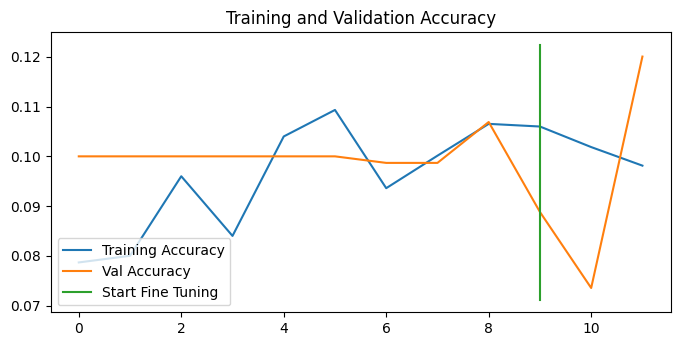

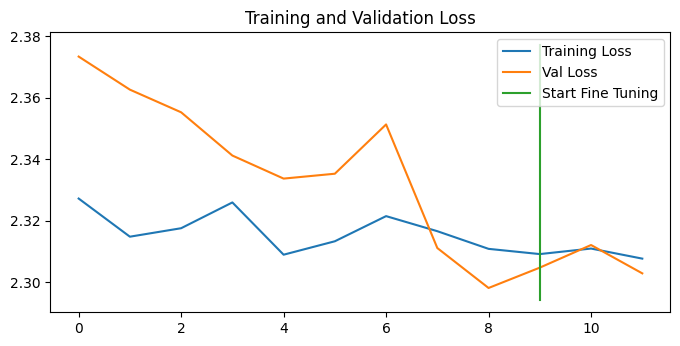

In [124]:
# How did fine tune get along with more data??
compare_history(history3, history4, initial_epochs)

In [125]:
model0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8205 - loss: 0.6609


[0.655651330947876, 0.8248000144958496]

Comparing all the models all at once
* You can use `tensorboard callbacks` - it's no longer available now